In [33]:
import pandas as pd

dados = pd.read_csv('../dados/CSV_Completo.csv')

animal = 'É animal mais atropelado'
animalEscolhido = 'rã-manteiga'

dados.loc[dados.Animal == animalEscolhido,animal] = 1
dados.loc[dados.Animal != animalEscolhido,animal] = 0


dados[animal] = dados[animal].astype(int)

del(dados['Animal'])
del(dados['Km'])
del(dados['Hora da Coleta'])


In [34]:
from collections import OrderedDict

categorias = {}
# categorias['Mês'] = dados['Mês']

for i in dados:
      categorias[i] = dados[i]
      # categorias[i] = i
      

for feature in categorias:
  categorias[feature] = list(OrderedDict.fromkeys(categorias[feature]))
  
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in dados:
    dados[i] = le.fit_transform(dados[i])
    
# print(dados)

categorias_cod = {}

for i in dados:
    categorias_cod[i] = dados[i]
    
for feature in categorias_cod:
  categorias_cod[feature] = list(OrderedDict.fromkeys(categorias_cod[feature]))
  
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Mês                       13096 non-null  int64
 1   Estação                   13096 non-null  int32
 2   Trecho                    13096 non-null  int64
 3   Sentido                   13096 non-null  int32
 4   Trecho macro              13096 non-null  int32
 5   Tipo De Pistas            13096 non-null  int32
 6   Numero de Pistas          13096 non-null  int32
 7   Tipo de Pavimento         13096 non-null  int32
 8   Numero de Faixas          13096 non-null  int32
 9   Velocidade Maxima         13096 non-null  int32
 10  Tipo da Chuva             13096 non-null  int32
 11  Intervencao               13096 non-null  int32
 12  Vazamento                 13096 non-null  int32
 13  Agua?                     13096 non-null  int32
 14  Vegetação Baixa?          13096 non-nu

0    12915
1      181
Name: É animal mais atropelado, dtype: int64


<BarContainer object of 2 artists>

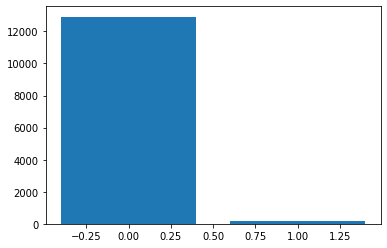

In [35]:
X = dados.iloc[:,:-1]
y = dados.iloc[:,-1]

import matplotlib.pyplot as plt

count = dados[animal].value_counts()
print(count)
plt.bar([0, 1], count) 

In [36]:
cod_cat = {}

for feature in categorias:
  cod_cat[feature] = {}
  for index, cat in enumerate(categorias[feature]):
    cods = categorias_cod[feature]
    cod_cat[feature].update({cods[index]:cat})


Escolhendo as 10 melhores features

In [37]:
from sklearn.feature_selection import SelectKBest, f_regression,  chi2

features = []
for i in X:
    features.append(i)

k = 10 # seleciona 10 features

sel_chi2 = SelectKBest(chi2, k = 10)

X_train_novo = sel_chi2.fit_transform(X, y)

print("os atributos escolhidos foram:")
atributosSelect = []
for j in sel_chi2.get_support(indices=True):
    atributosSelect.append(features[j])
    
print(atributosSelect)

colums = [animal]
col2 = []
for i in range(k):
    colums.append(i)
    col2.append(i)

print(X_train_novo.shape)

novoDf = pd.DataFrame(X_train_novo, y).reset_index()
novoDf.columns = [colums]

novoX = novoDf[col2]
novoY = novoDf[animal]


os atributos escolhidos foram:
['Mês', 'Estação', 'Trecho', 'Trecho macro', 'Tipo De Pistas', 'Numero de Pistas', 'Numero de Faixas', 'Velocidade Maxima', 'Local', 'Faixa de Quilometragem']
(13096, 10)


<BarContainer object of 2 artists>

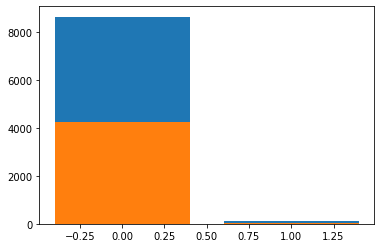

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split

dadosTreino, dadosTeste = train_test_split(novoDf, test_size = 0.33, random_state = 0)

countTreino = dadosTreino[animal].value_counts()

countTeste = dadosTeste[animal].value_counts()

plt.bar([0, 1], countTreino) 
plt.bar([0, 1], countTeste) 

In [39]:
treino_y = dadosTreino.pop(animal)
treino_x = dadosTreino

teste_y = dadosTeste.pop(animal)
teste_x = dadosTeste


In [40]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(treino_x, treino_y)

In [41]:
from sklearn.tree import DecisionTreeClassifier
decisionTree = DecisionTreeClassifier(max_depth=3)

from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(base_estimator=decisionTree, n_estimators=10)

bag_model = bag.fit(X_res, y_res)

y_predict = bag.predict(teste_x)

score = bag_model.score(teste_x,teste_y)
print(score)

0.6397501156871819


c:\Users\rayss\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      0.64      0.78      4270
           1       0.03      0.81      0.05        52

    accuracy                           0.64      4322
   macro avg       0.51      0.72      0.41      4322
weighted avg       0.98      0.64      0.77      4322

Matriz de confusão


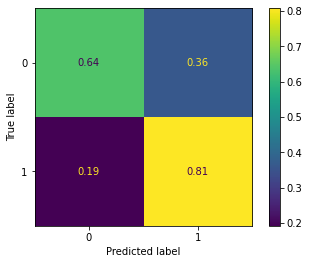

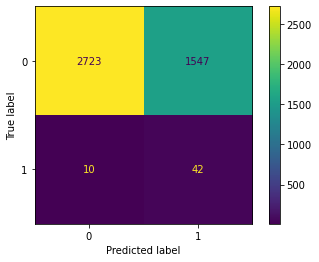

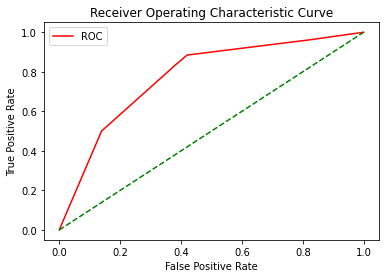

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(teste_y, y_predict, zero_division=0))
y_true = teste_y

print("Matriz de confusão")
matriz_confusaoPorc = confusion_matrix(y_true, y_predict, normalize = 'true')
matrizPorc = ConfusionMatrixDisplay(matriz_confusaoPorc)
matrizPorc.plot()

matriz_confusao = confusion_matrix(y_true, y_predict)
matriz = ConfusionMatrixDisplay(matriz_confusao)
matriz.plot()
plt.show()

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
from sklearn.metrics import roc_curve

TargetVarScore = bag.predict_proba(teste_x)
fper, tper, thresholds = roc_curve(teste_y, TargetVarScore[:, 1])
plot_roc_curve(fper, tper)